# Introduction




In [5]:
!pip install matplotlib seaborn pandas numpy scikit-learn wordcloud 


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


# Prepare for analysis

## Load packages

In [6]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [7]:
# Import from data_processing.py
from data_processing import combine_train_test

# Import from data_summary.py
from data_summary import (
    summarize_missing_values,
    summarize_frequent_items,
    summarize_unique_counts
)


from Intervals import add_age_interval, add_fare_interval, add_family_size

from name_parsing import parse_names, add_parsed_name_columns


from feature_engineering import (
    add_sex_pclass,
    add_family_type,
    unify_titles,
    classify_family_type,
    encode_sex_column,
    calculate_survival_rate_by_title_sex,
    split_features_and_target
)


In [8]:
# TODO: Add all hard coded parameters like file paths or model parameters here (DONE)
TRAIN_PATH = "/Users/jamallawal/Desktop/Cambridge MPhil Economics and Data Science/D200- Fundementals of Data Science/Problem Set 1/titanic_problem_set/train.csv"
TEST_PATH = "/Users/jamallawal/Desktop/Cambridge MPhil Economics and Data Science/D200- Fundementals of Data Science/Problem Set 1/titanic_problem_set/test.csv"

## Read the data

In [9]:
train_df = pd.read_csv(TRAIN_PATH)

# TODO: Put the path at the top of the script and replace with variable (DONE)
test_df = pd.read_csv(TEST_PATH)

# Preliminary data inspection

## Quick glimpse of the data
TODO: Think if you can abstract away much here.

In [10]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [14]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [15]:
test_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


## Few statistics on the data

### Missing data

In [16]:
# TODO: turn into function (DONE)
df_missing_train = summarize_missing_values(train_df)

In [17]:
# TODO: turn into function (DONE)
df_missing_test = summarize_missing_values(test_df)

### Most frequent data

In [18]:
# TODO: turn into function (DONE)
df_frequent_train = summarize_frequent_items(train_df)

In [19]:
# TODO: turn into function (DONE)
df_frequent_test = summarize_frequent_items(test_df)

### Unique values

In [20]:
# TODO: turn into function (DONE)
df_unique_counts_train = summarize_unique_counts(train_df)

In [21]:
# TODO: turn into function (DONE)
df_unique_counts_test = summarize_unique_counts(test_df)

# Exploratory data analysis

## Univariate analysis for all features


We show here two graphs in paralel:
* distribution of class values, split per Survived value
* comparison of class values, in train and test data


Let's first aggregate train and test data into one single dataframe, `all_df`.

In [22]:
# TODO: turn into function
all_df = combine_train_test(train_df, test_df)

In [23]:
all_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,set
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train


/var/folders/m4/s4q9k_wd0j37nwrthtttys900000gn/T/ipykernel_15673/2800895671.py:4: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.countplot(x="Sex", data=all_df, hue="set", palette=color_list)


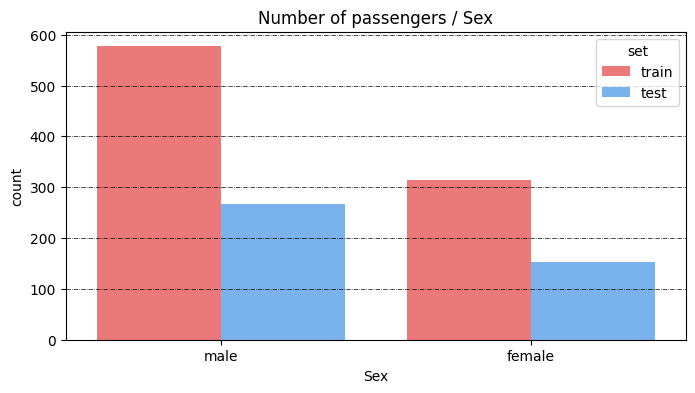

In [24]:
# Plot count pairs "Sex"
color_list = ["#FF6666", "#66B2FF", "#99FF99", "#FFCC99"]  # Updated colors for better distinction
f, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.countplot(x="Sex", data=all_df, hue="set", palette=color_list)
plt.grid(color="black", linestyle="-.", linewidth=0.5, axis="y", which="major")
ax.set_title("Number of passengers / Sex")
plt.show()

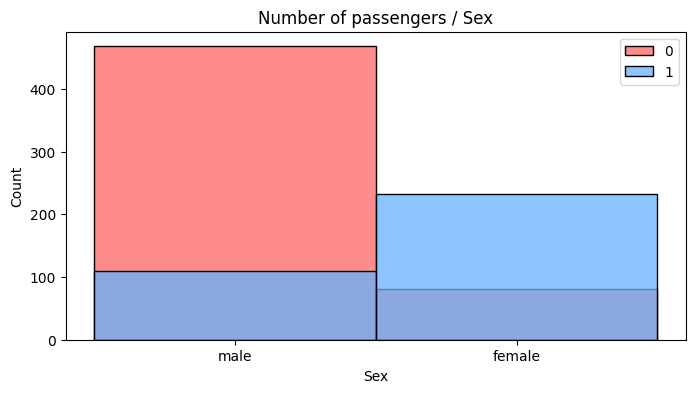

In [25]:
# Plot distribution pairs for "Sex" and hue as "Survived"
f, ax = plt.subplots(1, 1, figsize=(8, 4))
for i, h in enumerate(train_df["Survived"].unique()):
    g = sns.histplot(train_df.loc[train_df["Survived"]==h, "Sex"], 
                                  color=color_list[i], 
                                  ax=ax, 
                                  label=h)
ax.set_title("Number of passengers / Sex")
g.legend()
plt.show()

In [26]:
# Plot count pairs using all_df for the columns: Sex, Pclasss, SibSp, Parch, Embarked


In [27]:
# Plot count pairs using all_df for the columns: Sex, Pclasss, SibSp, Parch, Embarked and use "Survived" as hue.

In [28]:
# Plot distribution pairs for Age and Fare

In [29]:
# Plot distribution pairs for Age and Fare using "Survived" as hue

## Family size


Based on SibSp (sibilings or spouse) and Parch (parents or children), we set the Family Size field.

In [30]:
# TODO: turn into function (DONE)
all_df = add_family_size(all_df)

In [31]:
# TODO: turn into function (DONE)
train_df = add_family_size(train_df)

In [32]:
# Plot count pairs using all_df for the column "Family Size" and use "Survived" as hue.

## Age interval

In [33]:
# TODO: turn into function (DONE)
all_df = add_age_interval(all_df)

In [34]:
# TODO: turn into function (DONE)
train_df = add_age_interval(train_df)

In [35]:
all_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,set,Family Size,Age Interval
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train,2,1.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train,2,2.0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train,1,1.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train,2,2.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train,1,2.0


In [36]:
# Plot count pairs using all_df for the column "Age Interval" and use "Survived" as hue.

## Fare interval

In [37]:
all_df = add_fare_interval(all_df)

In [38]:
# TODO: turn into function ( DONE)
train_df = add_fare_interval(train_df)

In [39]:
# Plot count pairs using all_df for the column "Fare Interval"

Let's create a composed feature: Pclass + Sex.

In [40]:
# TODO: turn into function (DONE)
ttrain_df = add_sex_pclass(train_df)

In [41]:
# TODO: turn into function (DONE)
all_df = add_sex_pclass(all_df)

In [42]:
# Plot count pairs using all_df for the column "Fare Interval" and "Fare (grouped by survival)" with "Survived" as hue

## Process names


When we process names, we would like to extract the following information:

- Family name - this is the first word (or few first words, if a family name with multiple names), followed by a comma  
- Title - this follows just after the comma   
- Given name - this is the word or group of words following family name  
- Maiden name - for ladies, is given between parantheses  

We start with creating a function that parses the Name string and extract (if possible) these 4 elements


In [43]:
# TODO: also move this function to a separate file
train_df[['Family Name', 'Title', 'Given Name', 'Maiden Name']] = train_df.apply(parse_names, axis=1) 

In [44]:
# TODO: turn into function
all_df = add_parsed_name_columns(all_df, parse_names)

In [45]:
# TODO: turn into function
train_df = add_parsed_name_columns(train_df, parse_names)

## Multivariate analysis


Let's look now to the interaction of multiple features.

In [46]:
# TODO: Plot count pairs of "Age Interval" grouped by "Pclass"

In [47]:
# TODO: Plot count pairs of "Age Interval" grouped by "Embarked"

In [48]:
# TODO: Plot count pairs of "Pclass" grouped by "Fare Interval"

### Few more engineered data 


Let's create two more engineered features:  
* Family size interval: Single, Small, Large  
* Aggregated titles: Mr, Mrs, Master, Miss, and Rare  

In [49]:
# TODO: turn into function(DONE)
all_df, train_df = add_family_type([all_df, train_df])

In [50]:
# TODO: turn into function(DONE)
all_df, train_df = classify_family_type([all_df, train_df])


/Users/jamallawal/Desktop/Cambridge MPhil Economics and Data Science/D200- Fundementals of Data Science/Problem Set 1/titanic_problem_set/feature_engineering.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Single' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[size_col] == 1, type_col] = "Single"
/Users/jamallawal/Desktop/Cambridge MPhil Economics and Data Science/D200- Fundementals of Data Science/Problem Set 1/titanic_problem_set/feature_engineering.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Single' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[size_col] == 1, type_col] = "Single"


In [51]:
for dataset in [all_df, train_df]:
    dataset["Titles"] = dataset["Title"]

In [52]:
# TODO: turn into function
all_df, train_df = unify_titles([all_df, train_df])

In [53]:
# TODO: turn into function (DONE)
survival_rate_by_title_sex = calculate_survival_rate_by_title_sex(train_df)

# Baseline model

## Feature engineering: Map categorical value to numerical values

In [54]:
# TODO: turn into function
train_df, test_df = encode_sex_column([train_df, test_df])

Create train-validation split.

In [55]:
VALID_SIZE = 0.2
train, valid = train_test_split(train_df, test_size=VALID_SIZE, random_state=42, shuffle=True)

Define predictor features and target feature.

In [56]:
predictors = ["Sex", "Pclass"]
target = 'Survived'

Define the training and validation data and labels.

In [57]:
# TODO: turn into function
train_X, train_Y, valid_X, valid_Y = split_features_and_target(train, valid, predictors, target)

Initialize the classifiction algorithm.

In [58]:
# TODO: could this and the following code cells be turned into a function that returns the prediction?
clf = RandomForestClassifier(n_jobs=-1, 
                             random_state=42,
                             criterion="gini",
                             n_estimators=100,
                             verbose=False)

Fit the classifier with the training data.

In [59]:
clf.fit(train_X, train_Y)

RandomForestClassifier(n_jobs=-1, random_state=42, verbose=False)

Predict the train data (to check the training classification error).

In [60]:
preds_tr = clf.predict(train_X)

Predict the validation data.

In [61]:
preds = clf.predict(valid_X)

# Evaluation

## Classification report for training data.

In [62]:
print(metrics.classification_report(train_Y, preds_tr, target_names=['Not Survived', 'Survived']))

              precision    recall  f1-score   support

Not Survived       0.75      0.99      0.86       444
    Survived       0.96      0.47      0.63       268

    accuracy                           0.79       712
   macro avg       0.86      0.73      0.74       712
weighted avg       0.83      0.79      0.77       712



Classification report for validation data.

In [63]:
print(metrics.classification_report(valid_Y, preds, target_names=['Not Survived', 'Survived']))

              precision    recall  f1-score   support

Not Survived       0.73      0.96      0.83       105
    Survived       0.90      0.49      0.63        74

    accuracy                           0.77       179
   macro avg       0.81      0.72      0.73       179
weighted avg       0.80      0.77      0.75       179

